In [1]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *
from PIL import Image
import scipy.signal as signal
import warnings
warnings.simplefilter('ignore')

In [14]:
def plot_spike_counts(name, layer_shape, fig_num):
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    spike_copy = np.copy(spike_monitors[name].count)
    spike_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            spike_matrix[i,j] = spike_copy[i*x_L + j]

    unique_list = unique(spike_matrix)
    max_val = max(unique_list)
    min_val = min(unique_list)

    fig = figure(fig_num, figsize = (10, 10))
    im2 = imshow(spike_matrix, interpolation = "nearest", vmin = min_val, vmax = max_val , cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('number of spikes - ' + name + ' layer')

In [2]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
    print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [3]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/((sigma**2)))*(x**2 + y**2))
#     return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(2*math.pi*(sigma**2)))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 11
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

# CODE

In [18]:
stimuli_file = './pic_120_italic.tif'
weight_path = './initial_weights/'
save_path = './saved_weights/'

fig_num = 1

length = 120
field_size = 3                     # 2/3/4/5/6

w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

n_LGN = length*length
n_L4 = (length//(w_s*2))*(length//l_s)

num_epochs = 10

single_example_time = 0.35 * second
resting_time = 0.15 * second

## only if normalization is used
# weight = {}
# weight['input_L3'] = 70.                      # excitation one to one connection
# weight['L3_L3'] = 0.2                         # excitation one to all horizontal connection
# weight['L3_L2'] = 10.4                        # excitation one to one connection
# weight['L2_L3'] = 17.0                        # inhibition one to all backward connection (except predecessor)

delay = {}
delay = (0*ms, 10*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 20*ms
tc_post_1 = 20*ms
tc_post_2 = 40*ms
nu_pre =  0.0001
nu_post = 0.01
wmax = 100.0

input_intensity = 1.
start_input_intensity = input_intensity

update_interval = 2

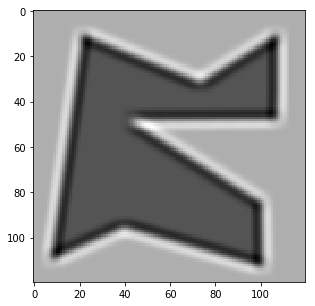

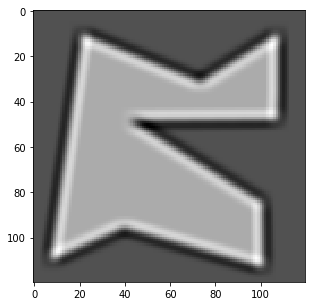

In [5]:
img = Image.open(stimuli_file)
img.load()
img_arr = np.asarray(img, dtype="int32")
stimuli = np.absolute(img_arr)/255

# fig = figure(fig_num, figsize = (10, 10))
# im2 = imshow(stimuli, vmin = np.min(stimuli), vmax = np.max(stimuli) , cmap = cmap.get_cmap('gray_r'))
# fig_num += 1

stimuli_on = signal.convolve(img, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,3,4)), mode='same')
fig = figure(fig_num, figsize = (5,5))
imgplot1 = imshow(stimuli_on, cmap=cmap.get_cmap('gray_r'))
fig_num += 1

stimuli_off = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,4,3)), mode='same')
fig = figure(fig_num, figsize = (5,5))
imgplot2 = imshow(stimuli_off, cmap=cmap.get_cmap('gray_r'))
fig_num += 1

In [6]:
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

neuron_groups = {}
neuron_groups['L4_on_v']     = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
neuron_groups['L4_on_i_v']   = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
neuron_groups['L4_off_v']    = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
neuron_groups['L4_off_i_v']  = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
neuron_groups['L4_v']        = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')


neuron_groups['L4_on_v'].v     = v_rest_e - 40.*mV
neuron_groups['L4_on_i_v'].v   = v_rest_i - 40.*mV
neuron_groups['L4_off_v'].v    = v_rest_i - 40.*mV
neuron_groups['L4_off_i_v'].v  = v_rest_i - 40.*mV
neuron_groups['L4_v'].v        = v_rest_e - 40.*mV

neuron_groups['L4_on_v'].theta   = np.ones((n_L4)) * 20.0*mV
neuron_groups['L4_v'].theta      = np.ones((n_L4)) * 20.0*mV

input_groups = {}
input_groups['LGN_on']   = PoissonGroup(n_LGN, 0*Hz)
input_groups['LGN_off']  = PoissonGroup(n_LGN, 0*Hz)

In [7]:
# without STDP
model = 'w : 1'
pre = 'g_e_post += w'
post = ''

# with STDP
stdp_model = '''
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost1/dt  = -post1/(tc_post_1)     : 1 (event-driven)
    dpost2/dt  = -post2/(tc_post_2)     : 1 (event-driven)
'''
stdp_pre = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_e_post += w;'
stdp_post = 'post1 = 1.; post2 = 1.; w = clip(w + nu_post * pre * post2, 0, wmax)'


connections = {}

# LGN on >> L4 on, without STDP
# 3*6 to one connection

shape = (n_LGN,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_on.npy', shape)

connections['LGN_on_L4_on_v']= Synapses(input_groups['LGN_on'], neuron_groups['L4_on_v'], model=model, on_pre=pre, on_post=post)
connections['LGN_on_L4_on_v'].connect(True)
connections['LGN_on_L4_on_v'].w = weightMatrix[connections['LGN_on_L4_on_v'].i, connections['LGN_on_L4_on_v'].j]
connections['LGN_on_L4_on_v'].delay = 'minDelay + rand() * deltaDelay'


# LGN off >> L4 on inhibitory, without STDP
# 3*6 to one connection

shape = (n_LGN,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_on.npy', shape)

connections['LGN_off_L4_on_i_v']= Synapses(input_groups['LGN_off'], neuron_groups['L4_on_i_v'], model=model, on_pre=pre, on_post=post)
connections['LGN_off_L4_on_i_v'].connect(True)
connections['LGN_off_L4_on_i_v'].w = weightMatrix[connections['LGN_off_L4_on_i_v'].i, connections['LGN_off_L4_on_i_v'].j]
connections['LGN_off_L4_on_i_v'].delay = 'minDelay + rand() * deltaDelay'


# LGN off >> L4 off, without STDP
# 3*6 to one connection

shape = (n_LGN,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_off.npy', shape)

connections['LGN_off_L4_off_v']= Synapses(input_groups['LGN_off'], neuron_groups['L4_off_v'], model=model, on_pre=pre, on_post=post)
connections['LGN_off_L4_off_v'].connect(True)
connections['LGN_off_L4_off_v'].w = weightMatrix[connections['LGN_off_L4_off_v'].i, connections['LGN_off_L4_off_v'].j]
connections['LGN_off_L4_off_v'].delay = 'minDelay + rand() * deltaDelay'


# LGN on >> L4 off inhibitory, without STDP
# 3*6 to one connection

shape = (n_LGN,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_off.npy', shape)

connections['LGN_on_L4_off_i_v']= Synapses(input_groups['LGN_on'], neuron_groups['L4_off_i_v'], model=model, on_pre=pre, on_post=post)
connections['LGN_on_L4_off_i_v'].connect(True)
connections['LGN_on_L4_off_i_v'].w = weightMatrix[connections['LGN_on_L4_off_i_v'].i, connections['LGN_on_L4_off_i_v'].j]
connections['LGN_on_L4_off_i_v'].delay = 'minDelay + rand() * deltaDelay'


# L4 on inhibitory >> L4 on, without STDP
# one to one connection

shape = (n_L4,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', shape)

connections['L4_on_i_L4_on_v']= Synapses(neuron_groups['L4_on_v'], neuron_groups['L4_on_i_v'], model=model, on_pre=pre, on_post=post)
connections['L4_on_i_L4_on_v'].connect(True)
connections['L4_on_i_L4_on_v'].w = weightMatrix[connections['L4_on_i_L4_on_v'].i, connections['L4_on_i_L4_on_v'].j]
connections['L4_on_i_L4_on_v'].delay = 'minDelay + rand() * deltaDelay'


# L4 off inhibitory >> L4 off, without STDP
# one to one connection

shape = (n_L4,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', shape)

connections['L4_off_i_L4_off_v']= Synapses(neuron_groups['L4_off_v'], neuron_groups['L4_off_i_v'], model=model, on_pre=pre, on_post=post)
connections['L4_off_i_L4_off_v'].connect(True)
connections['L4_off_i_L4_off_v'].w = weightMatrix[connections['L4_off_i_L4_off_v'].i, connections['L4_off_i_L4_off_v'].j]
connections['L4_off_i_L4_off_v'].delay = 'minDelay + rand() * deltaDelay'


# L4 on >> L4, without STDP
# one to one connection

shape = (n_L4,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', shape)

connections['L4_on_L4_v']= Synapses(neuron_groups['L4_on_v'], neuron_groups['L4_v'], model=model, on_pre=pre, on_post=post)
connections['L4_on_L4_v'].connect(True)
connections['L4_on_L4_v'].w = weightMatrix[connections['L4_on_L4_v'].i, connections['L4_on_L4_v'].j]
connections['L4_on_L4_v'].delay = 'minDelay + rand() * deltaDelay'


# L4 off >> L4, without STDP
# one to one connection

shape = (n_L4,n_L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', shape)

connections['L4_off_L4_v']= Synapses(neuron_groups['L4_off_v'], neuron_groups['L4_v'], model=model, on_pre=pre, on_post=post)
connections['L4_off_L4_v'].connect(True)
connections['L4_off_L4_v'].w = weightMatrix[connections['L4_off_L4_v'].i, connections['L4_off_L4_v'].j]
connections['L4_off_L4_v'].delay = 'minDelay + rand() * deltaDelay'

(7200, 3) ./initial_weights/LGN_L4_v_on.npy


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


(7200, 3) ./initial_weights/LGN_L4_v_on.npy
(7200, 3) ./initial_weights/LGN_L4_v_off.npy
(7200, 3) ./initial_weights/LGN_L4_v_off.npy
(400, 3) ./initial_weights/L4_L4.npy
(400, 3) ./initial_weights/L4_L4.npy
(400, 3) ./initial_weights/L4_L4.npy
(400, 3) ./initial_weights/L4_L4.npy


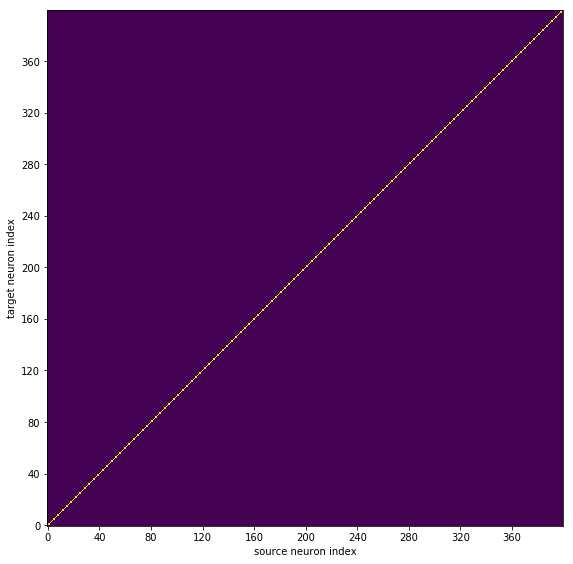

In [8]:
plt.figure(5, figsize=(10,10))
# brian_plot(connections['LGN_off_L4_on_i_v'].w)
# brian_plot(connections['L4_off_i_L4_off_v'].w)
brian_plot(connections['L4_off_L4_v'].w)
subplot(1,1,1)

In [9]:
# plot connections here

In [10]:
spike_counter = SpikeMonitor(neuron_groups['L4_v'])

# used for ploting after training
rate_monitors = {}
spike_monitors = {}

rate_monitors['LGN_on']      = PopulationRateMonitor(input_groups['LGN_on'])
rate_monitors['LGN_off']     = PopulationRateMonitor(input_groups['LGN_off'])
rate_monitors['L4_on_v']     = PopulationRateMonitor(neuron_groups['L4_on_v'])
rate_monitors['L4_on_i_v']   = PopulationRateMonitor(neuron_groups['L4_on_i_v'])
rate_monitors['L4_off_v']    = PopulationRateMonitor(neuron_groups['L4_off_v'])
rate_monitors['L4_off_i_v']  = PopulationRateMonitor(neuron_groups['L4_off_i_v'])
rate_monitors['L4_v']        = PopulationRateMonitor(neuron_groups['L4_v'])

spike_monitors['LGN_on']      = SpikeMonitor(input_groups['LGN_on'])
spike_monitors['LGN_off']     = SpikeMonitor(input_groups['LGN_off'])
spike_monitors['L4_on_v']     = SpikeMonitor(neuron_groups['L4_on_v'])
spike_monitors['L4_on_i_v']   = SpikeMonitor(neuron_groups['L4_on_i_v'])
spike_monitors['L4_off_v']    = SpikeMonitor(neuron_groups['L4_off_v'])
spike_monitors['L4_off_i_v']  = SpikeMonitor(neuron_groups['L4_off_i_v'])
spike_monitors['L4_v']        = SpikeMonitor(neuron_groups['L4_v'])

In [11]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors]:
    for key in obj_list:
        print(key, obj_list[key])
        net.add(obj_list[key])
print('spike counter', spike_counter)
net.add(spike_counter)

L4_on_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
L4_on_i_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
L4_off_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
L4_off_i_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')
L4_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')
LGN_on PoissonGroup(14400, rates=0. * hertz)
LGN_off PoissonGroup(14400, rates=0. * hertz)
LGN_on_L4_on_v Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses')
LGN_off_L4_on_i_v Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_1')
LGN_off_L4_off_v Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, or

In [12]:
previous_spike_count = np.zeros(n_L4)

input_groups['LGN_on'].rates = 0 * Hz
input_groups['LGN_off'].rates = 0 * Hz

net.run(0*second)

j = 0

In [13]:
while j < (num_epochs):
#     normalize_weights()
    
    spike_rates_on = stimuli_on.reshape((n_LGN)) / 8. *  input_intensity
    spike_rates_off = stimuli_off.reshape((n_LGN)) / 8. *  input_intensity
    
    input_groups['LGN_on'].rates = spike_rates_on * Hz
    input_groups['LGN_off'].rates = spike_rates_off * Hz
    
    print('run example number:', j, 'of', num_epochs)
    
    net.run(single_example_time, report='text')   # 0.35 s

#     if j % update_interval == 0:
#         plot_one_to_one('LGN_L6_o', n_LGN, fig_num)
#         fig_num += 1

    current_spike_count = np.asarray(spike_counter.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counter.count[:])
    
    if np.sum(current_spike_count) < 5:
        print("F - spike count", np.sum(current_spike_count))
        input_intensity += 1
        
        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        net.run(resting_time) 
    
    else:     
        print("S - spike count", np.sum(current_spike_count))
        
        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', num_epochs)

        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        
        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1

run example number: 0 of 10
Starting simulation at t=0. s for a duration of 0.35 s
0.2906 (83%) simulated in 10s, estimated 2s remaining.
0.35 (100%) simulated in 11s
S - spike count 755.0
run example number: 1 of 10
Starting simulation at t=0.5 s for a duration of 0.35 s
0.12546470588235298 (35%) simulated in 10s, estimated 18s remaining.
0.35 (100%) simulated in 11s
S - spike count 1254
run example number: 2 of 10
Starting simulation at t=1. s for a duration of 0.35 s
0.07676666666666666 (21%) simulated in 10s, estimated 36s remaining.
0.35 (100%) simulated in 11s
S - spike count 1223
run example number: 3 of 10
Starting simulation at t=1.5 s for a duration of 0.35 s
0.04614324324324324 (13%) simulated in 10s, estimated 1m 6s remaining.
0.35 (100%) simulated in 14s
S - spike count 1210
run example number: 4 of 10
Starting simulation at t=2. s for a duration of 0.35 s
0.03934893617021279 (11%) simulated in 10s, estimated 1m 19s remaining.
0.35 (100%) simulated in 12s
S - spike count 1

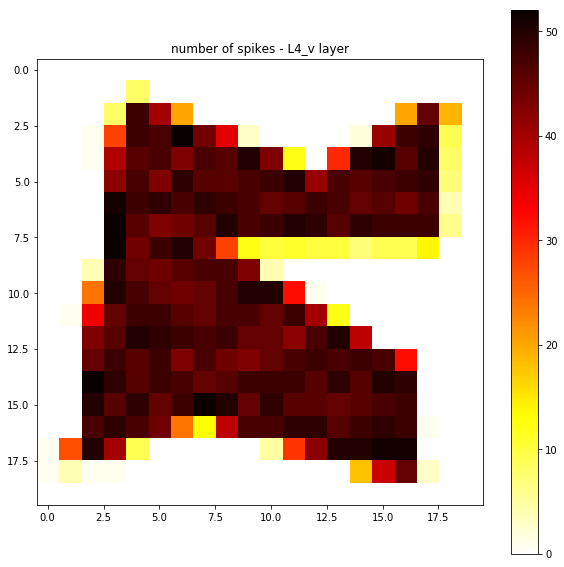

In [22]:
plot_spike_counts('L4_v', (length//(w_s*2), length//l_s), fig_num)

In [20]:
length//w_s*2

80

In [21]:
w_s

3